In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append("../src")

from preprocessing.sampling import FinDataStructures
import preprocessing.labels as l

%load_ext autoreload

The autoreload module is not an IPython extension.


In [2]:
df_etheur = pd.read_csv("../src/data/ETHEUR.csv", names=["timestamp", "price", "vol"])
df_etheur["timestamp"] = pd.to_datetime(df_etheur["timestamp"], unit="s")
# df_etheur = pd.read_parquet("../src/data/IVE_tickbidask.parquet")


finstructs = FinDataStructures()
finstructs.df = df_etheur
finstructs.define_data()
finstructs.tick_data = finstructs.tick_bar(finstructs.df, n=1000)
finstructs.volme_data = finstructs.volume_bar(finstructs.df, volume_tick=1_000)
finstructs.dollar_data = finstructs.dollar_bar(finstructs.df, dollar_vol_tick=10_000)

volume_imbalance_bar = finstructs.calculate_imbalance_bars(finstructs.df.bv_VIB, alpha=0.9)
dollar_imbalance_bar = finstructs.calculate_imbalance_bars(finstructs.df.bv_DIB, alpha=0.9)

### Exercises chapter 3
#### 3.1
a) Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).

In [3]:
df_dollar = finstructs.dollar_data
df_dollar = df_dollar.set_index('timestamp')
df_dollar = df_dollar[~df_dollar.index.duplicated(keep='first')]
close = df_dollar.price.resample('1min').ohlc().dropna().close

In [4]:
dailyReturns, dailyStd = l.getDailyVol(df_dollar.price, span0=100)

<Axes: xlabel='timestamp'>

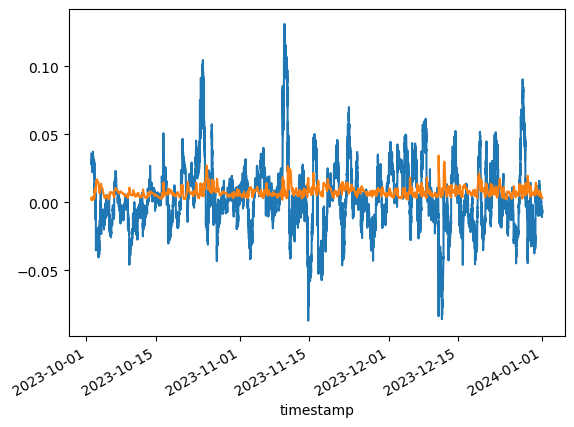

In [5]:
dailyReturns.plot()
dailyStd.plot()

In [19]:
dailyStdMean = dailyStd.mean()
df_dollar_returns = df_dollar.price.diff()/df_dollar.price
close_returns = close.diff()/close
# close_returns = close.diff()/close

In [11]:
tEvents = l.getTEvents(gRaw = df_dollar.price, 
           h = dailyStd.max()+.03)

<Axes: xlabel='timestamp'>

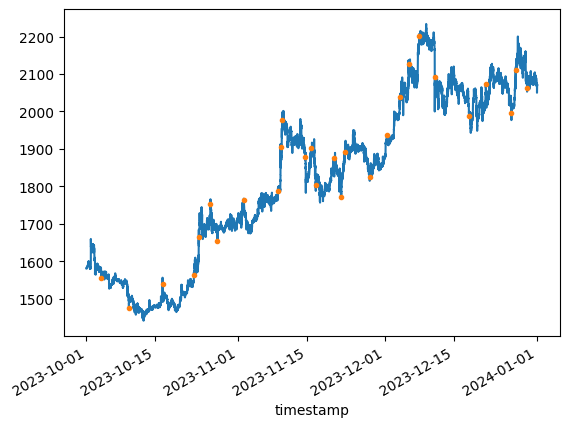

In [12]:
df_dollar.price.plot()
df_dollar['price'].loc[tEvents].plot(marker='.',ls='',label='tEvents')

#### (b) Use Snippet 3.4 on a pandas series t1, where numDays = 1.

In [25]:
def define_vertical_barrier(close, tEvents, numDays):
    """one way to define a vertical barrier. For each index in tEvents,
    it finds the timestamp of the next price bar at or immediately
    after a number of days numDays. This vertical barrier
    can be passed as optional argument t1 in getEvents.
    """
    tEvents_index = close.loc[tEvents].index
    t1 = close.index.searchsorted(tEvents_index + pd.Timedelta(days=numDays))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=tEvents[: t1.shape[0]])  # NaNs at end
    return t1

In [52]:
t1 = define_vertical_barrier(close=df_dollar.price, tEvents=tEvents, numDays=1)

#### (c) On those sampled features, apply the triple-barrier method, where ptSl = [1,1] and t1 is the series you created in point 1.b.

In [53]:
close = df_dollar.price
ptSl = [1,1]
# we should set a target in order to set horizontal barriers properly 
# this can be a constant or, even better it should be return based on, for example, realized volatility 
# we need to define it as series with index from t1 to 
trgt = [dailyStd.loc[i] for i in t1.index]
trgt = pd.Series(trgt, t1.index)

# 1) get target
# trgt = trgt.loc[tEvents]

# 2) get t1 (max holding period)
# we can use the vertical barriers we define above, i.e. max 1 day holding period or define nans
# if we define nans we are basically choosing [1,1,0] strat
if t1 is False:
    t1 = pd.Series(pd.NaT, index=tEvents)

# now we want to add targets to each of the vertical barriers (these will define horizontal barriers)
# further we add side, in this case it is a simple buy signal (we will define later more)
# 3) form events object, apply stop loss on t1
side_ = pd.Series(1.0, index=trgt.index)
events = pd.concat({"t1": t1, "trgt": trgt, "side": side_}, axis=1).dropna(
    subset=["trgt"]
)

events_ = events  # .loc[molecule]
out = events_[["t1"]].copy(deep=True)

In [54]:
if ptSl[0] > 0:
    pt = ptSl[0] * events_["trgt"]
else:
    pt = pd.Series(index=events.index)  # NaNs
if ptSl[1] > 0:
    sl = -ptSl[1] * events_["trgt"]
else:
    sl = pd.Series(index=events.index)  # NaNs

In [56]:
for loc, data in events_.fillna(close.index[-1]).iterrows():  # .iteritems():
    t1 = data.t1
    df0 = close[loc:t1]  # path prices
    df0 = (df0 / close[loc] - 1) * events_.at[loc, "side"]  # path returns
    out.loc[loc, "sl"] = df0[df0 < sl[loc]].index.min()  # earliest stop loss.
    out.loc[loc, "pt"] = df0[df0 > pt[loc]].index.min()  # earliest profit taking.

events["t1"] = df0.dropna(how="all").min(
    axis=1
)  # pd.min ignores nan events=events.drop('side',axis=1)

AttributeError: 'DataFrame' object has no attribute 'iteritems'

In [28]:
t1_barriers = define_vertical_barrier(df_dollar.price, tEvents, numDays=1)
# horizontal_barrier_upper = [df_dollar.price[i]+dailyStd.loc[i]*df_dollar.price[i] for i in t1_barriers.index]
# horizontal_barrier_lower = [df_dollar.price[i]-dailyStd.loc[i]*df_dollar.price[i] for i in t1_barriers.index]

In [828]:
df_t1_barriers = pd.DataFrame(t1_barriers)
df_t1_barriers['trgt_upper'] = horizontal_barrier_upper
df_t1_barriers['trgt_lower'] = horizontal_barrier_lower
df_t1_barriers.columns = ['t1', 'trgt_upper', 'trgt_lower']

In [832]:
ptSl = [1.01,.99]
out = tripple_barrier_method(df_dollar.price,
                             df_t1_barriers , 
                             ptSl)

In [833]:
out

,t1,sl,pt
2023-10-05 15:04:43,2023-10-06 15:10:10,NaT,NaT
2023-10-11 02:34:58,2023-10-12 03:30:32,NaT,2023-10-11 09:38:28
2023-10-16 13:30:16,2023-10-17 13:35:20,2023-10-16 13:41:57,NaT
2023-10-22 23:00:44,2023-10-23 23:01:22,NaT,2023-10-23 03:47:00
2023-10-23 23:00:40,2023-10-24 23:08:31,2023-10-23 23:11:08,2023-10-24 02:45:39
2023-10-26 08:02:37,2023-10-27 08:09:38,2023-10-26 11:46:12,NaT
2023-11-05 17:40:26,2023-11-06 17:41:28,2023-11-05 21:33:21,NaT
2023-11-09 15:00:53,2023-11-10 15:01:03,NaT,2023-11-09 15:16:48
2023-11-09 23:37:05,2023-11-10 23:38:01,2023-11-10 12:13:42,NaT
2023-11-14 17:53:54,2023-11-15 17:54:30,2023-11-14 18:43:19,NaT


### 1d
Apply getBins to generate the labels.

In [840]:
px, labels = getBins(df_t1_barriers, df_dollar.price)

### 3.2 
From exercise 1, use Snippet 3.8 to drop rare labels.

In [858]:
#we do not drop any since we only have 1 and 0
labels_dropped = dropLabels(labels , minPct=.05)

### 3.3 
Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical
barrier is the one touched first.

In [885]:
out['first_touched'] = out[['t1','sl','pt']].min(axis=1)
out['outcome'] = out[['t1','sl','pt']].idxmin(axis=1)

In [889]:
px, labels = getBins(out, df_dollar.price)

In [891]:
labels.head(5)

,ret,bin
2023-10-05 15:04:43,0.000000,0.0
2023-10-11 02:34:58,0.014685,1.0
2023-10-16 13:30:16,-0.020945,-1.0
2023-10-22 23:00:44,0.019194,1.0
2023-10-23 23:00:40,-0.022170,-1.0


#### 3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, the model suggests a side, but not a size of the bet.
(a) Derive meta-labels for ptSl = [1,2] and t1 where numDays = 1. Use as
trgt the daily standard deviation as computed by Snippet 3.1. <br>
(b) Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underlying model (the crossing moving average) has decided the side, {−1,1}.

In [1001]:
dailyReturns, dailyStd = getDailyVol(df_dollar.price, span0=100)

In [1002]:
t1_barriers = define_vertical_barrier(df_dollar.price, tEvents, numDays=1)
horizontal_barrier_upper = [df_dollar.price[i]+dailyStd.loc[i]*df_dollar.price[i] for i in t1_barriers.index]
horizontal_barrier_lower = [df_dollar.price[i]-dailyStd.loc[i]*df_dollar.price[i] for i in t1_barriers.index]

# return_targets = [dailyReturns.loc[i] for i in t1_barriers.index]
# return_targets_pos = np.abs(return_targets)

trgt = [dailyStd.loc[i] for i in t1_barriers.index]
trgt = pd.Series(trgt, t1_barriers.index)

In [1030]:
events = getEvents(df_dollar.price, 
          tEvents, 
          ptSl0=1, 
          ptSl1=2, 
          trgt=trgt, 
          minRet=.01, 
          t1=t1_barriers)

In [1036]:
getBins(events,df_dollar.price)

,ret,bin
2023-10-04 00:31:51,0.008874,1.0
2023-10-23 22:42:43,0.012619,1.0
2023-10-26 07:29:43,-0.025533,0.0
2023-11-09 15:16:48,0.017646,1.0
2023-11-09 22:48:26,0.010628,1.0
2023-11-15 20:29:03,-0.037883,0.0
2023-11-16 19:21:23,0.015197,1.0
2023-11-22 18:55:44,0.012488,1.0
2023-12-11 02:12:43,-0.030198,0.0


In [1037]:
events

,t1,trgt,side
2023-10-04 00:31:51,2023-10-05 00:44:06,0.012861,1.0
2023-10-23 22:42:43,2023-10-24 02:17:43,0.012449,1.0
2023-10-26 07:29:43,2023-10-26 14:32:08,0.012322,1.0
2023-11-09 15:16:48,2023-11-09 21:25:10,0.017193,1.0
2023-11-09 22:48:26,2023-11-09 23:50:02,0.010377,1.0
2023-11-15 20:29:03,2023-11-16 15:43:52,0.018013,1.0
2023-11-16 19:21:23,2023-11-17 02:28:21,0.014092,1.0
2023-11-22 18:55:44,2023-11-22 21:11:17,0.011257,1.0
2023-12-11 02:12:43,2023-12-11 02:12:57,0.014870,1.0


<Axes: xlabel='timestamp'>

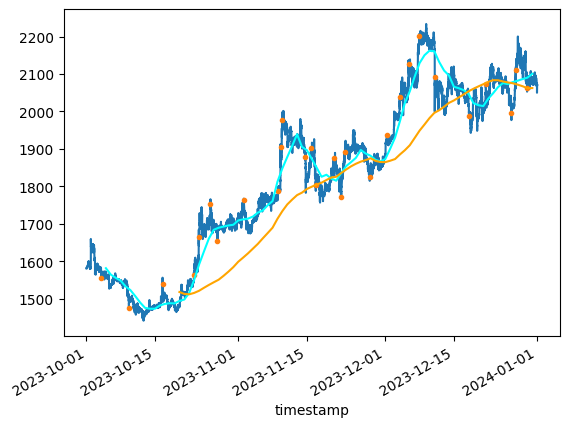

In [1039]:
df_dollar.price.plot()
df_dollar['price'].loc[tEvents].plot(marker='.',ls='',label='tEvents')
df_dollar['price'].resample('D').ohlc()['close'].rolling(window=7).mean().plot(color='cyan')
df_dollar['price'].resample('D').ohlc()['close'].rolling(window=20).mean().plot(color='orange')

In [1082]:
def get_ma(df, window=7):
    ma = df_dollar['price'].resample('D').ohlc()['close'].rolling(window=window).mean()
    ma = ma.reset_index()
    ma.columns = ['date','ma7']
    df = pd.merge(df,
         ma,
         on='date')
    return df

In [1077]:
df_dollar['date'] = pd.to_datetime(df_dollar.index.date)

In [1084]:
df_dollar = get_ma(df_dollar, window=7)

<Axes: >

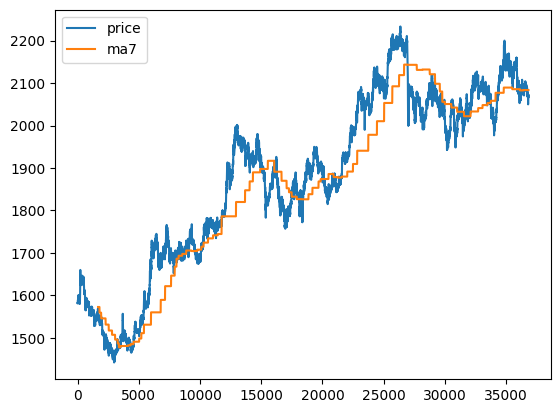

In [1086]:
df_dollar[['price','ma7']].plot()

In [1011]:
df_dollar['price'].ohlc('day').close

AttributeError: 'Series' object has no attribute 'ohlc'

In [1004]:
labels

,t1,trgt,side
2023-10-04 00:31:51,2023-10-05 00:44:06,0.012861,1.0
2023-10-23 22:42:43,2023-10-24 02:17:43,0.012449,1.0
2023-10-26 07:29:43,2023-10-26 14:32:08,0.012322,1.0
2023-11-09 15:16:48,2023-11-09 21:25:10,0.017193,1.0
2023-11-09 22:48:26,2023-11-09 23:50:02,0.010377,1.0
2023-11-15 20:29:03,2023-11-16 15:43:52,0.018013,1.0
2023-11-16 19:21:23,2023-11-17 02:28:21,0.014092,1.0
2023-11-22 18:55:44,2023-11-22 21:11:17,0.011257,1.0
2023-12-11 02:12:43,2023-12-11 02:12:57,0.014870,1.0


In [45]:
dd = finstructs.dollar_data

In [48]:
dd["t1"] = pd.to_datetime("2023-12-05")
dd["trgt"] = 0.1
ptSl = [1, 1]

/var/folders/r5/9t0c3s6n5h3_mrcqsxp1k9y80000gp/T/ipykernel_51769/4050004888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['t1'] = pd.to_datetime('2023-12-05')
/var/folders/r5/9t0c3s6n5h3_mrcqsxp1k9y80000gp/T/ipykernel_51769/4050004888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['trgt'] = 0.1
